# Sudoku Puzzle Extractor

The idea is to extract all the squares from a sudoku puzzle and then feed it into a CNN that recognize handwritten digit. All my previous attempts using pure deep learning failed miserably due to complicated output and lack of dataset. So, I turned to google and found that this task can be done more effortlessly using OpenCV. 

My approach is based off [this comment](https://stackoverflow.com/questions/59182827/how-to-get-the-cells-of-a-sudoku-grid-with-opencv/59184973#59184973) from a StackOverflow post with my own modification for it to perform better. 

**Steps**

1. Localize the sudoku puzzle
2. Remove all the digits
3. Repair the gridlines
4. Find all the squares

*This is my second time writing this notebook, funny thing happened, I accidentally deleted my notebook and it's irrevocable :). A great reminder that I should always use git even its for notebooks*

## Package

In [623]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Step 0: Get an image with sudoku puzzle

An ideal image should have the following characteristic:
- No overlapping of numbers and gridlines
- Clear

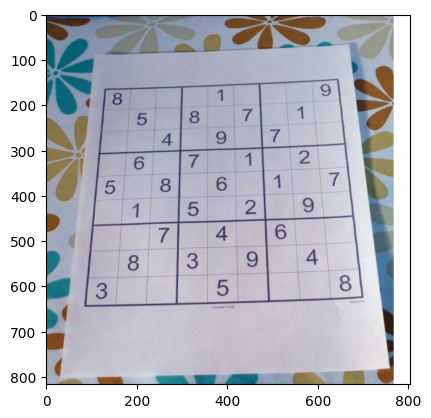

In [624]:
im = cv2.imread('./test.png')
plt.imshow(im)

We will also prepare a binary version of the same image for extracting contours in the later steps. This can be done through [thersholding](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) or [canny edge detection](https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html).

Contours to be extracted is based off the color white. In our case, we need to make sure the digits and the gridlines are in white.

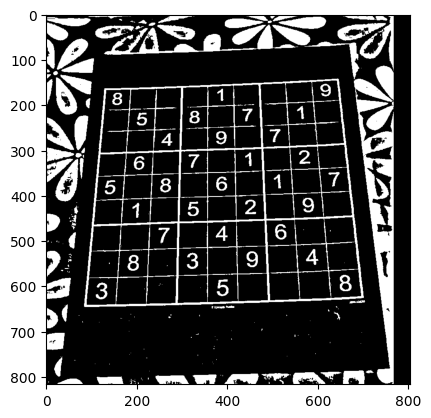

In [625]:
# Convert to gray scale
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# Apply adaptive threshoding
thresh = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)

plt.imshow(thresh, cmap='gray')

## Step 1: Localize the sudoku puzzle

Notice that there are noises outside the sudoku puzzle, so to avoid picking up these noises, we can lozalize the puzzle for a better effect on the extraction of digits later.

We can localize the sudoku puzzle by finding the largest contour. The motivation for this comes from the fact that the sudoku puzzle in the target image has the largest area in most cases.

More about contours can be found [here](https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html).

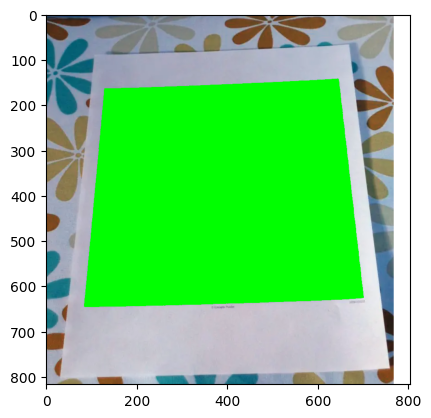

In [626]:
# Find all contours
cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Find the contour with the max area
cnt = max(cnts, key=cv2.contourArea)

# Displaying the found contour
im_copy = np.copy(im)
cv2.drawContours(im_copy, [cnt], -1, (0, 255, 0), -1)
plt.imshow(im_copy)

The sudoku puzzle is localized, now we find the smallest rectangle (bounding rectangle) that contains the sudoku puzzle and then crop it.

The size of the cropped images are also standardized to 600x600.

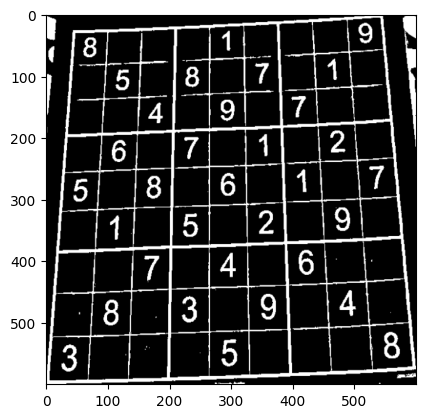

In [627]:
# Find bounding rectangle
x, y, w, h = cv2.boundingRect(cnt)

im = im[y:y+h, x:x+w, :]
im = cv2.resize(im, (600, 600), interpolation = cv2.INTER_AREA)
thresh = thresh[y:y+h, x:x+w]
thresh = cv2.resize(thresh, (600, 600), interpolation = cv2.INTER_AREA)

plt.imshow(thresh, cmap='gray')

Additionally, we will save a mask for the sudoku puzzle for one of the later stpes.

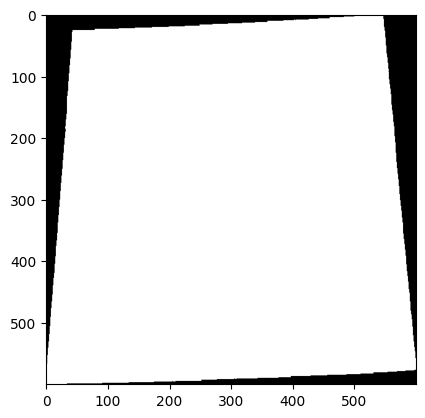

In [628]:
# Find all contours
cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Find the contour with the max area
cnt = max(cnts, key=cv2.contourArea)

# Create mask
mask = np.zeros_like(thresh, dtype=np.uint8)
cv2.drawContours(mask, [cnt], -1, (255, 255, 255), -1)
plt.imshow(mask, cmap='gray')

## Step 2: Remove all the digits

The purpose of this step is to allow us to extract the squares in the sudoku puzzle more easily. 

The digit are also found through contours. For all the contours we found, we mark all contours that has area < 1000 as the digits. And then, we "remove" it.

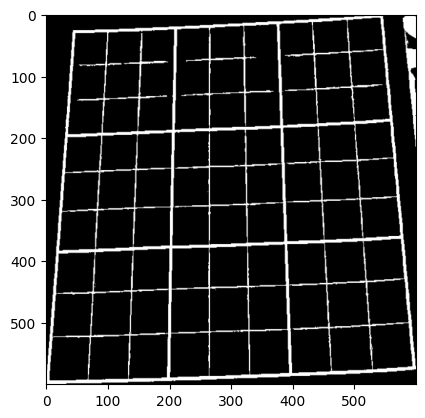

In [629]:
# Find all contours
cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Filter to get the digit contours
cnts = [i for i in cnts if cv2.contourArea(i) < 1000]

# "Remove" the digit contours
cv2.drawContours(thresh, cnts, -1, (0, 0, 0), -1)
plt.imshow(thresh, cmap='gray')

## Step 3: Repair the gridlines

Looking at the output from the previous step, it's clear that some of the gridlines are not connected properly and this will obviously be an issue for us when we want to extract the square. So, we need to repair it.

This is done through [morphological transformation](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html).

The number of iterations in both morphological transformation needs to be fine-tuned for some situations.

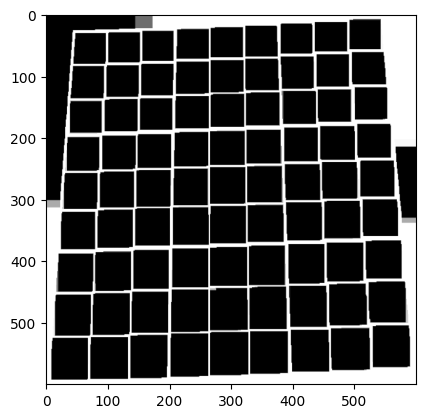

In [630]:
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, vertical_kernel, iterations=11)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, horizontal_kernel, iterations=11)

plt.imshow(thresh, cmap='gray')

## Step 4: Find all the squares

Now that we have a somewhat looking good gridlines, we can extract the squares now. Since contour is found based off the color white, we will invert the binary image so that each square is in white and all squares get recognized as a contour.

But before that, notice that there are also some noises outside the sudoku grid on the side. Let's use the mask we created earlier to deal with this.

We will make everything outside the sudoku puzzle white so that when we invert the binary image only square is white.

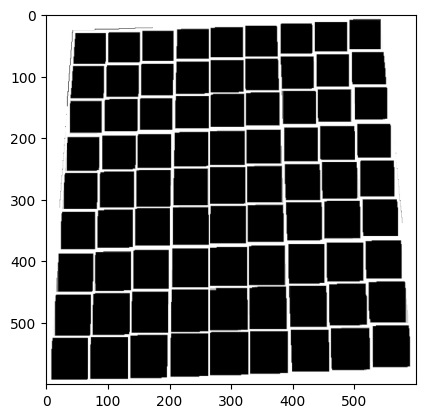

In [631]:
mask = 255 - mask
thresh = cv2.bitwise_or(thresh,mask)
plt.imshow(thresh, cmap='gray')

Since contour is found based off the color white, we will invert the binary image so that each square is in white and all squares get recognized as a contour.

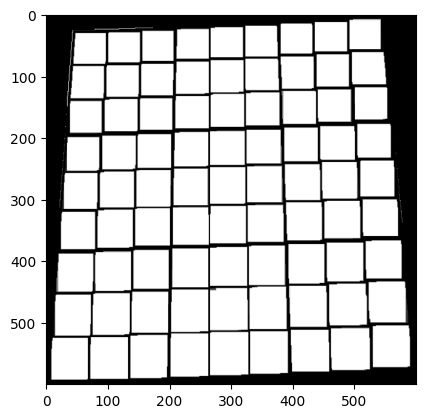

In [632]:
thresh = 255 - thresh
plt.imshow(thresh, cmap='gray')

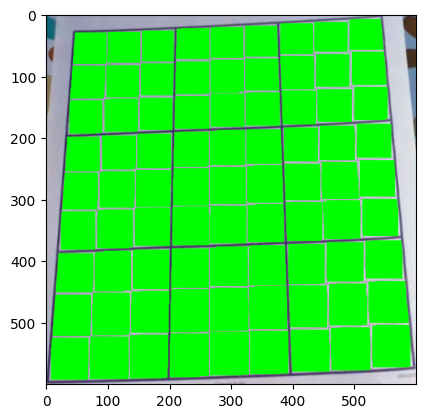

In [635]:
cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# To filter out the noises
cnts = [i for i in cnts if cv2.contourArea(i) > 100]
im_copy = np.copy(im)
cv2.drawContours(im_copy, cnts, -1, (0, 255, 0), -1)
plt.imshow(im_copy)

Now we have located each squares. We need to know the location of each square, we will do that by using a sorting contour utility function.

We will first sort from top to bottom and then left to right.

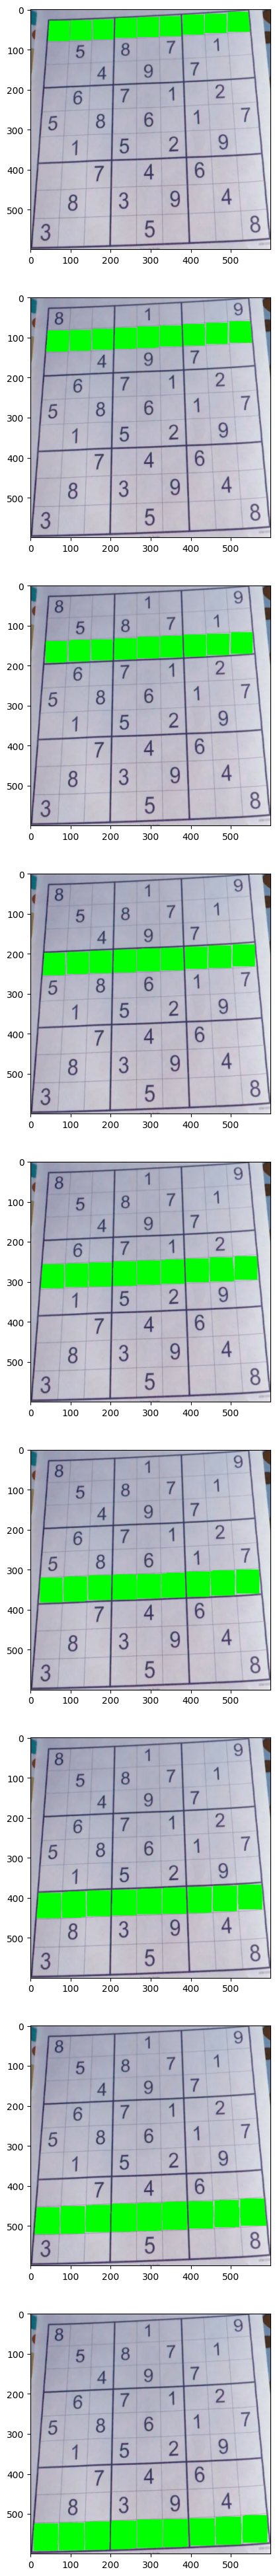

In [636]:
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

cnts, _ = sort_contours(cnts, 'top-to-bottom')

sudoku = []
for i in range(9):
    row, _ = sort_contours(cnts[i*9: (i+1)*9])
    sudoku.append(row)

fig, axes = plt.subplots(9, 1, figsize=(50, 50))

for i in range(9):
    im_copy = np.copy(im)
    cv2.drawContours(im_copy, sudoku[i], -1, (0, 255, 0), -1)
    axes[i].imshow(im_copy)

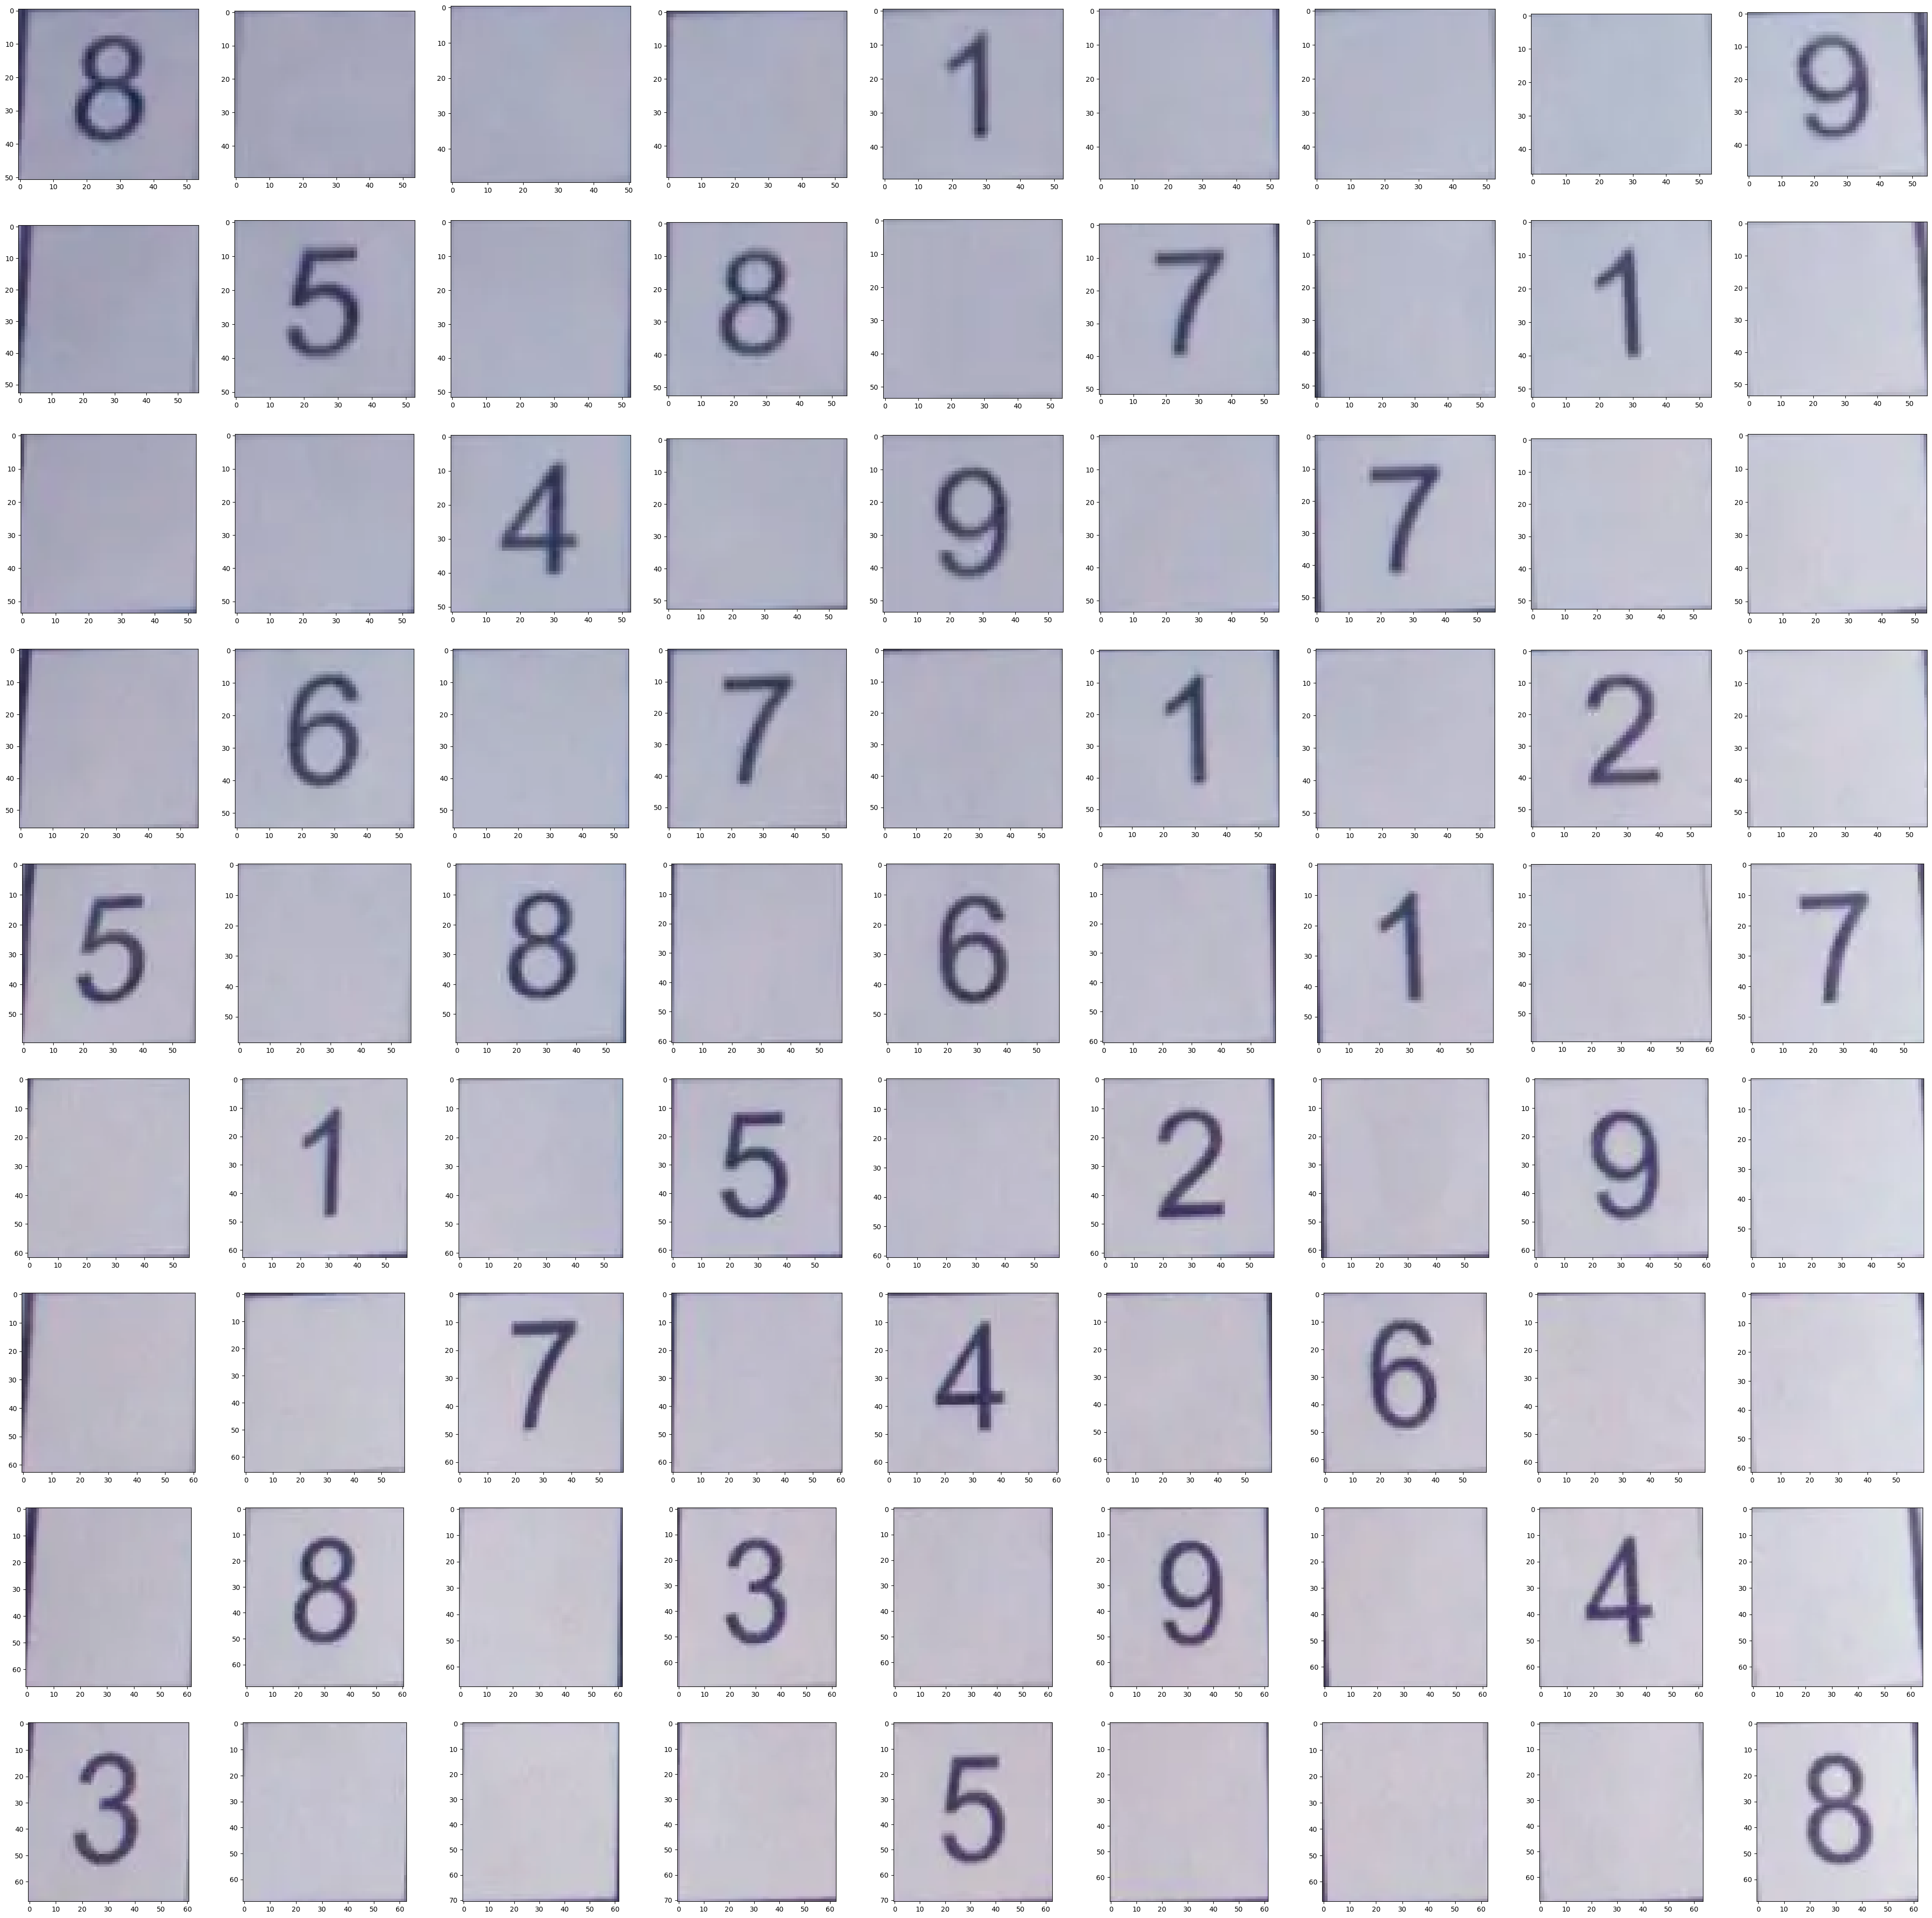

In [637]:
fig, axs = plt.subplots(9, 9, figsize=(50, 50))

for i in range(9):
    for j in range(9):
        x, y, w, h = cv2.boundingRect(sudoku[i][j])
        axs[i, j].imshow(im[y:y+h, x:x+w, :])